# Data Loading

In [29]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

pd.set_option('display.max_rows', 200)

In [30]:
datapath = '../data/processed'

In [47]:
datas = pd.read_csv(os.path.join(datapath, 'streamflow_sequence.csv'), index_col='date', parse_dates=['date'])
site_info = pd.read_csv(os.path.join(datapath, 'site_reference.csv'))

# start_date = datas.index[0]
# end_date = datas.index[-1]

datas.to_csv('../data/interim/original_streamflow.csv')

datas_fill = datas.copy()

# site_complete = datas.isnull().mean()[datas.isnull().mean() == 0].index.tolist()
# site_to_fill = datas.isnull().mean()[datas.isnull().mean() > 0].index.tolist()

In [48]:
startDate = datas.apply(lambda x: x[x.notnull()].index[0])

In [57]:
print('''distribution of start available year''')
startDate.dt.year.value_counts()

distribution of start available year


1960    23
1911    22
1959    21
1961    19
1958    17
1930    17
1950    16
1987    16
1928    16
1941    16
1957    16
1970    15
1951    15
1983    15
1939    15
1912    14
1927    14
1929    13
1952    13
1940    13
1965    12
1956    12
1966    12
1968    12
1953    11
1986    11
1962    11
1998    10
1921    10
1942    10
1989     9
1990     9
1969     9
1916     9
1985     8
1967     8
1994     8
1949     8
1955     8
1980     8
1971     7
1997     7
1948     7
1946     7
1954     7
2008     7
1923     7
1904     7
1910     7
1922     7
2000     6
1988     6
1964     6
1963     6
1993     6
1920     6
1926     6
1938     6
1947     6
2005     6
2002     6
1933     6
1944     5
1975     5
1901     5
2004     5
1936     5
1982     4
1906     4
1909     4
2006     4
2001     4
1919     4
1943     4
1991     3
1992     3
2003     3
1995     3
1999     3
1974     3
1945     3
1973     3
1937     3
1932     3
1931     3
1907     3
1925     3
1924     3
1976     2
1915     2
2007     2

In [58]:
startDate.dt.year.describe()

count     794.000000
mean     1953.639798
std        27.820560
min      1891.000000
25%      1930.000000
50%      1956.000000
75%      1970.750000
max      2008.000000
dtype: float64

In [59]:
import datetime

In [60]:
#choose 1960 as my start year

start_date = datetime.datetime(1960, 1, 1)

In [61]:
endDate = datas.apply(lambda x: x[x.notnull()].index[-1])

In [62]:
print('''distribution of end available year''')
endDate.dt.year.value_counts()

distribution of end available year


2019    324
2018    161
1979     21
1980     19
1986     17
1983     16
1982     15
1990     14
1978     14
1987     12
1994     12
1985      9
1981      9
1992      9
2011      8
1993      8
1969      7
1975      7
1973      7
2010      6
2017      6
2005      6
2014      5
2009      5
1996      5
2008      5
1972      5
2016      4
1988      4
1971      4
1976      4
2015      4
2013      3
2012      3
1977      3
2004      3
2002      3
1997      3
1995      3
1970      3
1984      3
2003      2
2001      2
1998      2
1991      2
1989      2
2000      2
2006      1
2007      1
1974      1
dtype: int64

In [63]:
endDate.dt.year.min()

1969

In [64]:
endDate.dt.year.max()

2019

In [27]:
def null_dates(s):
    tmp = s[s.isnull()].index.tolist()
    time_seqs = []
    time_seq = []
    if len(tmp) == 1:
        return [tmp]
    for i, j in zip(tmp[1:], tmp[:-1]):
        if i - j == pd.Timedelta('1D'):
            time_seq.append(j)
        else:
            time_seq.append(j)
            time_seqs.append(time_seq)
            time_seq = []
    if time_seq != []:
        time_seq.append(tmp[-1])
        time_seqs.append(time_seq)
    return time_seqs

def determine_seq(timesep, start_date, end_date):
    if len(timesep) == 1:
        return {'type':'D', 'dates':timesep, 'length': len(timesep)}
    if timesep[0] == start_date:
        return {'type':'F', 'dates':timesep, 'length': len(timesep)}
    if timesep[-1] == end_date:
        return {'type':'E', 'dates':timesep, 'length': len(timesep)}
    else:
        return {'type':'M', 'dates':timesep, 'length': len(timesep)}

In [28]:
fill_dates = {s: null_dates(datas[s]) for s in site_to_fill}
fill_types = {s: [determine_seq(i, start_date, end_date) for i in fill_dates[s]] for s in site_to_fill}
closest_sites = {}
for site in site_to_fill:
    site_lat, site_lon = site_info.loc[site].lat, site_info.loc[site].long
    closest_sites[site] = ((site_info.lat - site_lat)**2 + (site_info.long - site_lon)**2)\
                            .apply(np.sqrt).sort_values().index.tolist()[1:]
flatten = lambda t: [item for sublist in t for item in sublist]
missing_dates = {s:flatten(fill_dates[s]) for s in site_to_fill}
type_distribution = {s: [(i['type'], i['length'])for i in fill_types[s]] for s in site_to_fill}

KeyboardInterrupt: 

# Missing Data EDA

In [17]:
print(f'number of stations has null values {(datas.isnull().mean() != 0).sum()}')

print(f'number of stations does not have null values {(datas.isnull().mean() == 0).sum()}')

number of stations has null values 16
number of stations does not have null values 12


site no: 11208000


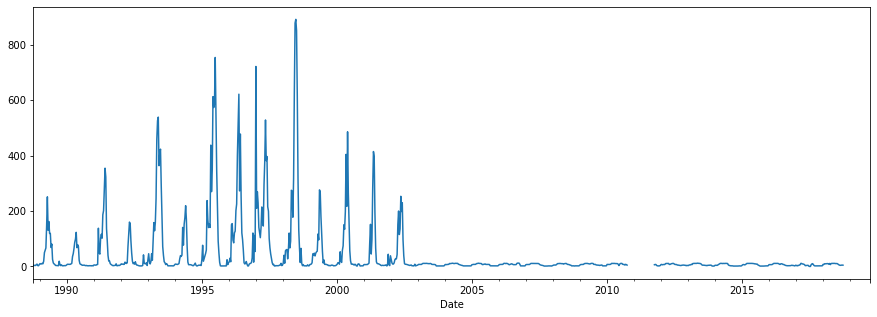

site no: 11216200


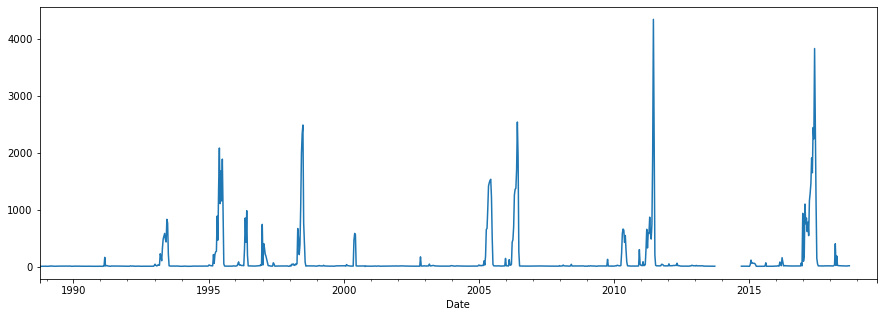

site no: 11237500


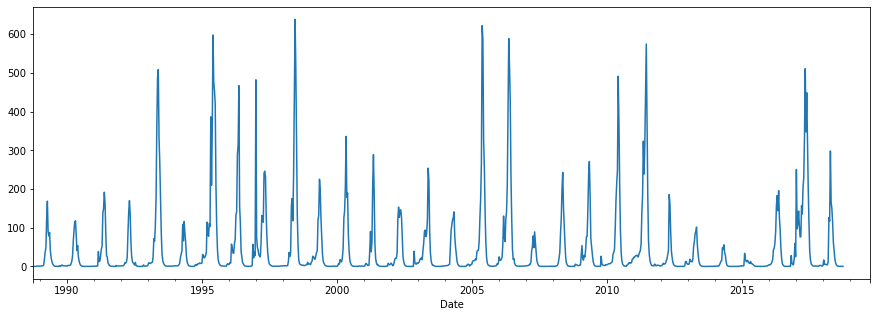

site no: 11238600


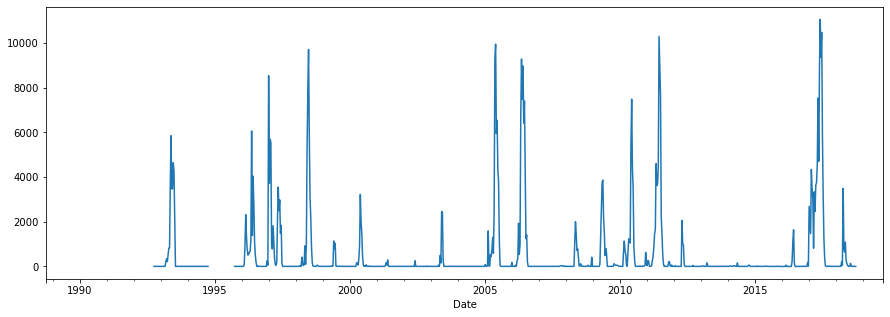

site no: 11244000


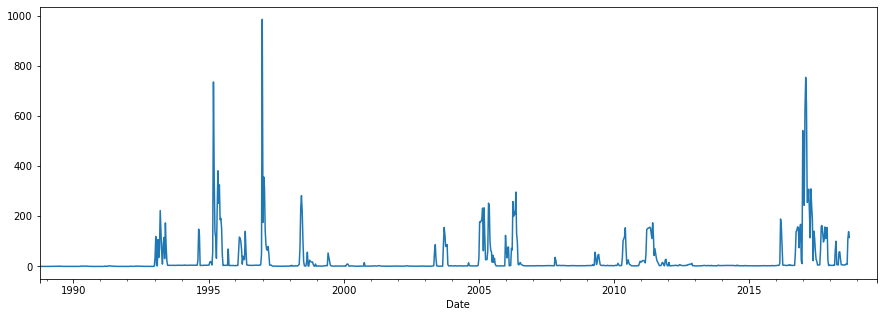

site no: 11246500


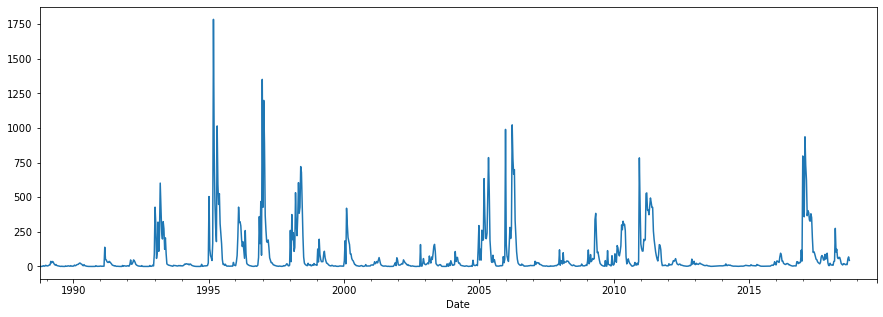

site no: 11278000


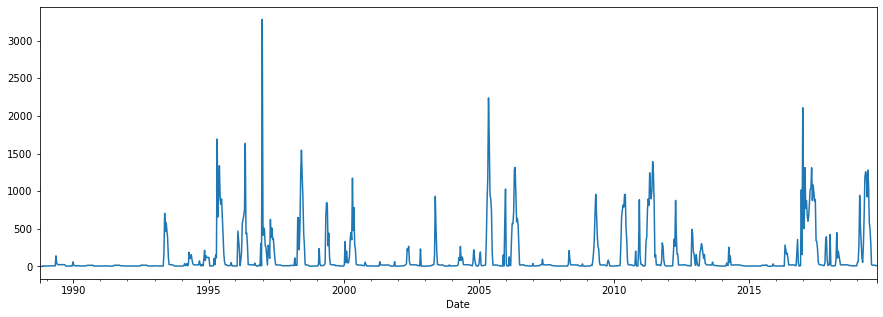

site no: 11298000


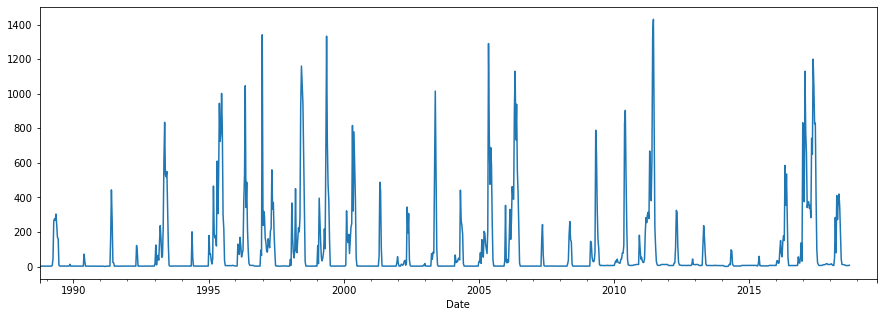

site no: 11299600


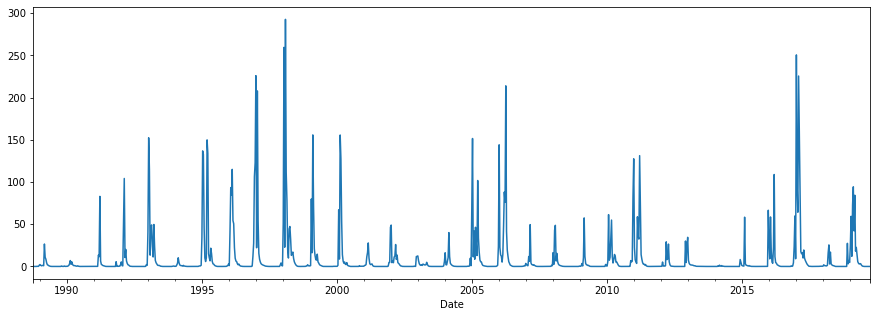

site no: 11315000


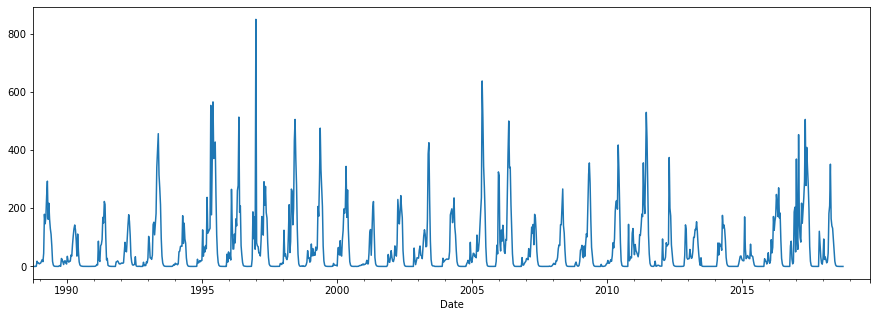

site no: 11316800


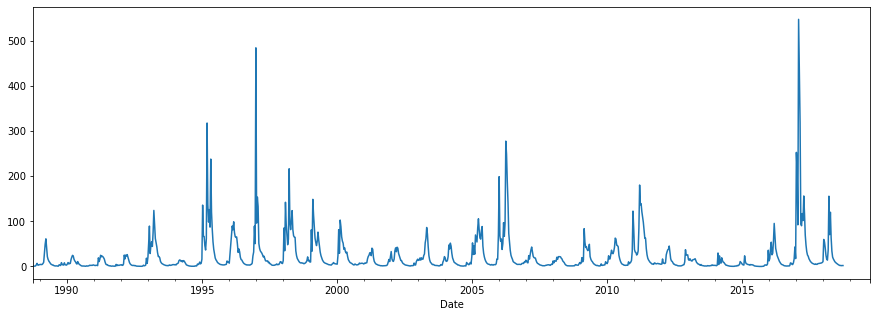

site no: 11396200


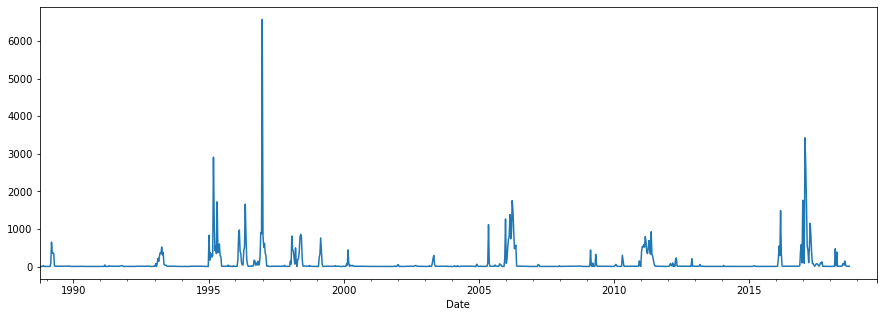

site no: 11416500


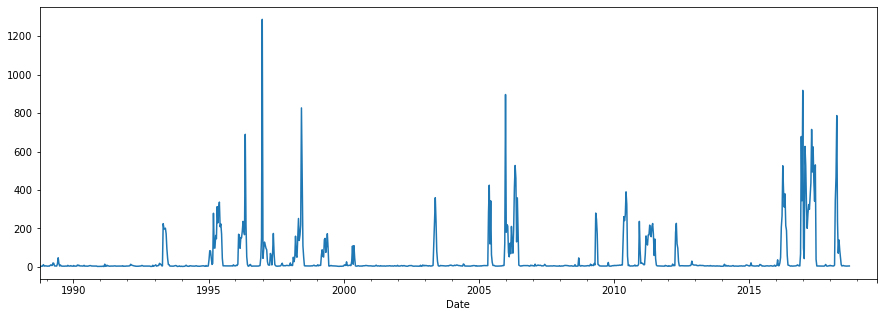

site no: 11427700


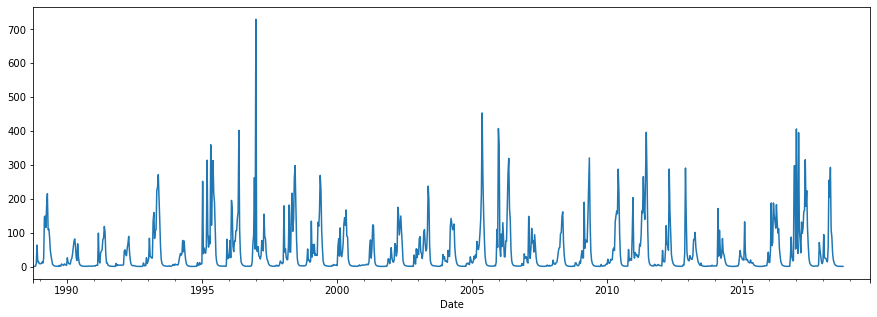

site no: 11427750


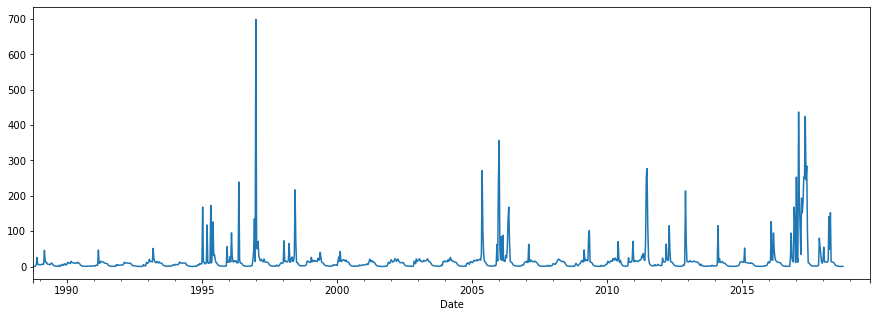

site no: 11436000


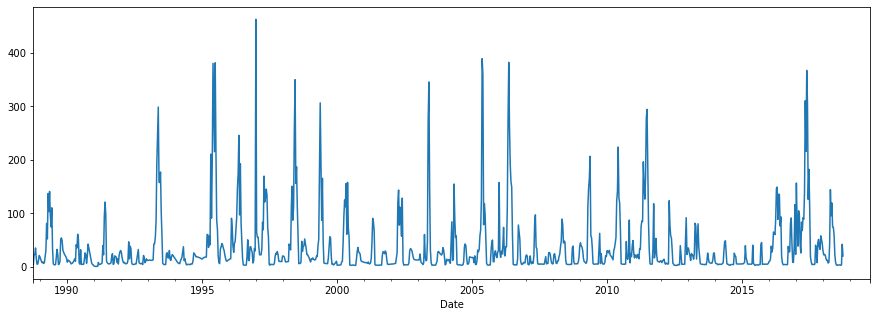

In [18]:
for i in site_to_fill:
    print(f'site no: {i}')
    datas[i].resample('10d').mean().plot()
    plt.show()

In [19]:
type_distribution

{11208000: [('D', 1),
  ('M', 17),
  ('M', 3),
  ('D', 1),
  ('D', 1),
  ('M', 6),
  ('M', 2),
  ('M', 23),
  ('D', 1),
  ('M', 2),
  ('M', 365),
  ('E', 365)],
 11216200: [('M', 364), ('E', 365)],
 11237500: [('E', 365)],
 11238600: [('F', 1461), ('M', 365), ('E', 365)],
 11244000: [('E', 365)],
 11246500: [('E', 365)],
 11278000: [('M', 2)],
 11298000: [('E', 365)],
 11299600: [('D', 1), ('M', 2)],
 11315000: [('E', 365)],
 11316800: [('E', 365)],
 11396200: [('E', 365)],
 11416500: [('E', 365)],
 11427700: [('E', 365)],
 11427750: [('E', 365)],
 11436000: [('E', 365)]}

In [20]:
#stategy

##D: missing a day's info
###using mean previous day's and next day's streamflow to impute

##F: missing at Front
###using nearby sites streamflow of same day to impute

##M: missing at Middle
###using autoencoder model to impute

##E: missing at End
###leave to forcasting model

# Imputing missingness at Single Day

In [21]:
for s in site_to_fill:
    for i in fill_types[s]:
        if i['type'] == 'D':
            datas_fill.loc[i['dates'][0], s] = np.mean([datas.loc[i['dates'][0] + pd.Timedelta('1D'), s], \
                    datas.loc[i['dates'][0] - pd.Timedelta('1D'), s]])

# Imputing missingness at Front

In [22]:
site_filled = set()
for s in site_to_fill:
    for i in fill_types[s]:
        if i['type'] == 'F':
            for d in i['dates']:
                tmp = complete_datas.loc[d, closest_sites[s]].dropna()
                if len(tmp) >= 3:
                    datas_fill.loc[d, s] = tmp[:3].mean()
                elif len(tmp) == 0:
                    datas_fill.loc[d, s] = datas_fill.loc[d - pd.Timedelta('1D'), s]
                else:
                    datas_fill.loc[d, s] = tmp.mean()
            site_filled.add(s)

In [23]:
site_filled

{11238600}

site no: 11238600


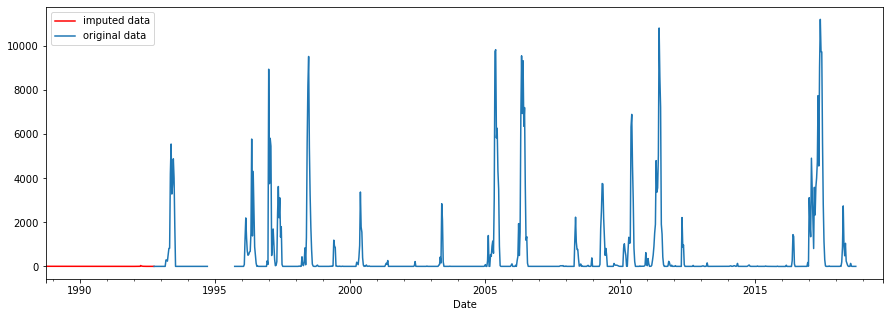

In [24]:
for s in site_filled:
    tmp_df = datas_fill[s].to_frame()
    tmp_df['missing'] = datas_fill[s].index.isin(datas[s].isnull()[datas[s].isnull()].index)
    tmp_original = tmp_df[tmp_df.missing != True][s]
    tmp_imputed = tmp_df[tmp_df.missing == True][s]
    if len(tmp_imputed)!=0:
        print(f'site no: {s}')
        fig,ax = plt.subplots(1,1)
        tmp_imputed.resample('10d').mean().plot(style='-', c = 'r', label='imputed data', ax=ax)
        tmp_original.resample('10d').mean().plot(style='-', label='original data', ax=ax)
        plt.legend()
        plt.show()

# Imputing missingness at Middle

In [25]:
fill_types_middle_prediction = {}
for s in site_to_fill:
    info = []
    for i in fill_types[s]:
        if i['type'] == 'M':
            info.append(i)
        if i['type'] == 'E':
            info.append(i)
    if info != []:
        fill_types_middle_prediction[s] = info

In [26]:
type_distribution_middle_prediction = {s: [(i['type'], i['length'])for i \
                                           in fill_types_middle_prediction[s]] for s in site_to_fill\
                                          if s in fill_types_middle_prediction.keys()}

In [27]:
# following items are to be filled

In [28]:
type_distribution_middle_prediction

{11208000: [('M', 17),
  ('M', 3),
  ('M', 6),
  ('M', 2),
  ('M', 23),
  ('M', 2),
  ('M', 365),
  ('E', 365)],
 11216200: [('M', 364), ('E', 365)],
 11237500: [('E', 365)],
 11238600: [('M', 365), ('E', 365)],
 11244000: [('E', 365)],
 11246500: [('E', 365)],
 11278000: [('M', 2)],
 11298000: [('E', 365)],
 11299600: [('M', 2)],
 11315000: [('E', 365)],
 11316800: [('E', 365)],
 11396200: [('E', 365)],
 11416500: [('E', 365)],
 11427700: [('E', 365)],
 11427750: [('E', 365)],
 11436000: [('E', 365)]}

## initialization with neighborhoods


In [29]:
site_filled = set()
for s in site_to_fill:
    for i in fill_types[s]:
        if i['type'] == 'M':
            for d in i['dates']:
                tmp = complete_datas.loc[d, closest_sites[s]].dropna()
                if len(tmp) >= 3:
                    datas_fill.loc[d, s] = tmp[:3].mean()
                elif len(tmp) == 0:
                    datas_fill.loc[d, s] = datas_fill.loc[d - pd.Timedelta('1D'), s]
                else:
                    datas_fill.loc[d, s] = tmp.mean()
            site_filled.add(s)

site no: 11208000


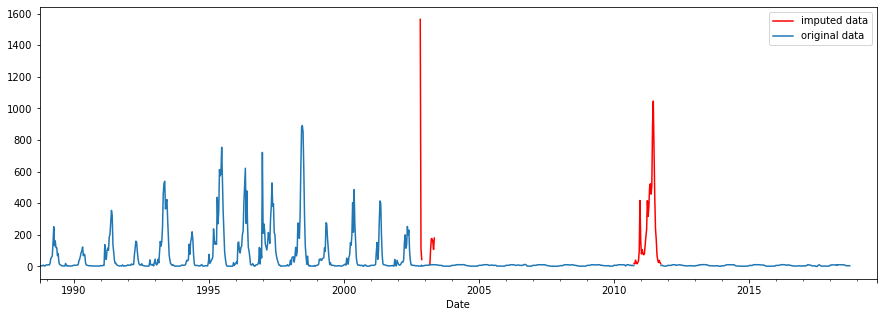

site no: 11216200


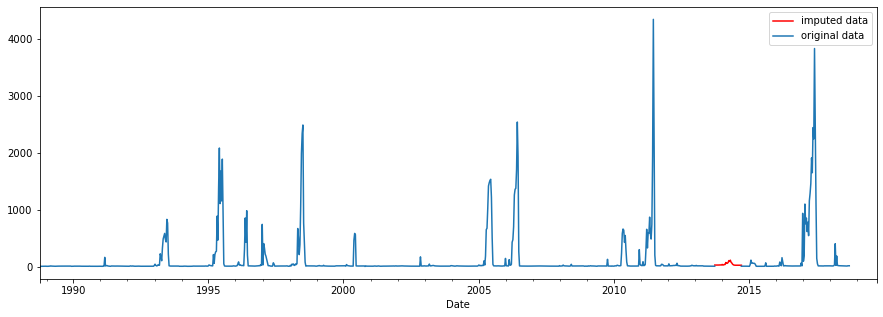

site no: 11238600


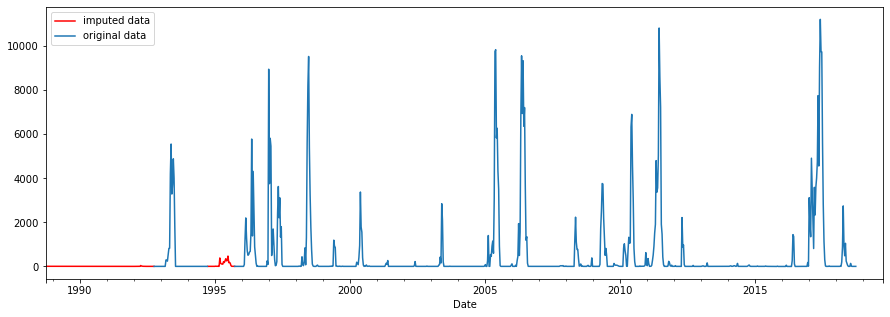

site no: 11299600


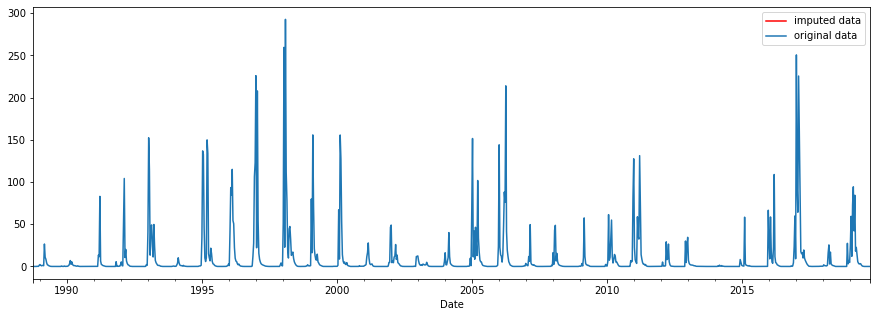

site no: 11278000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 18163.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


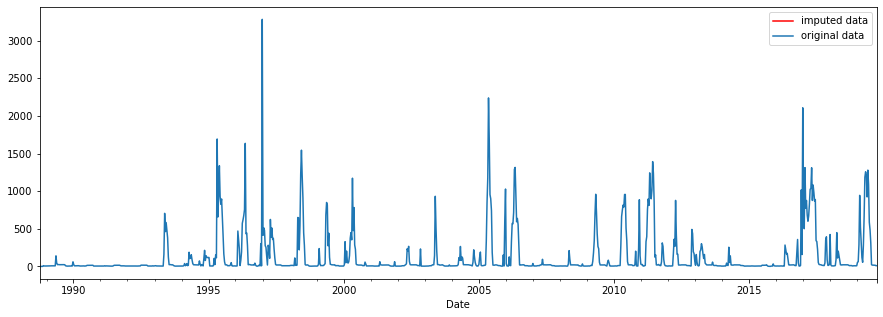

In [30]:
for s in site_filled:
    tmp_df = datas_fill[s].to_frame()
    tmp_df['missing'] = datas_fill[s].index.isin(datas[s].isnull()[datas[s].isnull()].index)
    tmp_original = tmp_df[tmp_df.missing != True][s]
    tmp_imputed = tmp_df[tmp_df.missing == True][s]
    if len(tmp_imputed)!=0:
        print(f'site no: {s}')
        fig,ax = plt.subplots(1,1)
        tmp_imputed.resample('10d').mean().plot(style='-', c = 'r', label='imputed data', ax=ax)
        tmp_original.resample('10d').mean().plot(style='-', label='original data', ax=ax)
        plt.legend()
        plt.show()

In [31]:
datas_fill.to_csv('./data/interim/dummy_filled.csv')